Notebook for experiments with DBScan algorithm by scikit learn
* distance matrix construction (parameter metric='precomputed')
* select:
    -  eps
    -  min_samples

* computing distance between clusterings  
-> sklearn.metrics.adjusted_rand_score  
-> sklearn.metrics.jaccard_score  
-> sklearn.metrics.adjusted_mutual_info_score  

* on all data
* feast by feast

In [2]:
# Imports
import numpy as np
import pandas as pd
import random
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, jaccard_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

data = pd.concat([responsories_all, antiphons_all])

In [4]:
# Select "more serious" feasts
freq_of_feasts = data['feast_id'].value_counts()
bigger_feasts = freq_of_feasts.drop(freq_of_feasts[freq_of_feasts.values < 100].index).index.tolist()
feasts_without_little = feasts[feasts['id'].isin(bigger_feasts)]
print(len(feasts_without_little))

387


In [5]:
# Metrics for measuring similarity of two sets ('chant sharingness')
def intersection_size(a : list, b : list):
    '''
    Function returns size of intersection of two sets
    '''
    return len(set(a).intersection(set(b)))

def Jaccard_metrics(a : list, b : list):
    '''
    Function returns value of Jaccard metrics applied on two sets
    '''
    if len(set(a) | set(b)) != 0:
        return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))
    else:
        return 0

In [6]:
# Source translate to int for smooth matrix indexing 
from collections import OrderedDict

source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1
    

def translate_source(source_id):
    return source_dict[source_id]

In [7]:
# Get source_id based on index to restore clusterings
index_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    index_dict[i] = id
    i += 1

def translate_index(index):
    return index_dict[index]

In [8]:
def get_distance_matrix_all(compare_func, sources):
    source_chants_dict = {}
    chants = data

    for source_id in sources:
        filt_source = chants['source_id'] == source_id
        source_chants_dict[source_id] = (chants[filt_source]['cantus_id']).tolist()
    
    distance_matrix = np.zeros([len(sources), len(sources)])
    for s_i in sources:
        for s_j in sources:
            distance_matrix[source_dict[s_i], source_dict[s_j]] = 1 - compare_func(source_chants_dict[s_i], source_chants_dict[s_j])
    
    return distance_matrix

In [9]:
def shuffle(perm, sources):
    shuffled_sources = [sources[j] for j in perm]
    return shuffled_sources

def unshuffle(perm, labels):
    unshuffled_labels = np.zeros(len(labels))
    for i, j in enumerate(perm):
        unshuffled_labels[j] = labels[i]
    return unshuffled_labels

In [17]:
EPS_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
MIN_SAMPLES_OPTIONS = [2, 3, 4, 5, 6]

In [18]:
def run_all_chants(n, eps, min_samples, drupals):
    community_variants = []
    num_of_clusters = []
    for _ in range(n):
            perm = list(range(len(drupals)))
            random.shuffle(perm)
            shuff_sources = shuffle(perm, drupals)
            distance_matrix = get_distance_matrix_all(Jaccard_metrics, shuff_sources)
            clustering = DBSCAN(eps=eps, min_samples=min_samples)
            clustering.fit(distance_matrix)
            num_of_clusters.append(len(set(clustering.labels_)))
            labels = unshuffle(perm, clustering.labels_)
            community_variants.append(labels)
    print(eps, min_samples)
    print(num_of_clusters)
    return community_variants, num_of_clusters

In [20]:
# Run experiment on all chants with changing parameters of DBscan
drupals = sources['drupal_path'].tolist()

# What do we wanna collect
num_of_clusters = [] #list of lists for each parametrization
more_clusters = []
max_jaccard = {'value' : 0, 'params' : (0, 0), 'avg_clus' : 0}
max_rand = {'value' : 0, 'params' : (0, 0), 'avg_clus' : 0}
max_mutual = {'value' : 0, 'params' : (0, 0), 'avg_clus' : 0}
all_rand = []
all_jaccard = []
all_mutual = []

# Try all basic parametrization options
for i in range(len(EPS_OPTIONS)):
    for j in range(len(MIN_SAMPLES_OPTIONS)):
        community_variants, num_of_labels = run_all_chants(n=5, eps=EPS_OPTIONS[i], min_samples=MIN_SAMPLES_OPTIONS[j], drupals=drupals)
        num_of_clusters.append(num_of_labels)
        rand = []
        jaccard = []
        mutual_info = []
        all_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
        for pair in all_pairs:
            rand.append(adjusted_rand_score(pair[0], pair[1]))
            mutual_info.append(adjusted_mutual_info_score(pair[0], pair[1]))
            jaccard.append(jaccard_score(pair[0], pair[1], average='micro'))
        
        all_rand.append(rand)
        all_jaccard.append(jaccard)
        all_mutual.append(mutual_info)

        if np.mean(jaccard) > max_jaccard['value'] and np.mean(jaccard) < 1:
            max_jaccard['value'] = np.mean(jaccard)
            max_jaccard['params'] = (EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])
            max_jaccard['avg_clus'] = np.mean(num_of_labels)
        if np.mean(rand) > max_rand['value'] and np.mean(rand) < 1:
            max_rand['value'] = np.mean(rand)
            max_rand['params'] = (EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])
            max_rand['avg_clus'] = np.mean(num_of_labels)
        if np.mean(mutual_info) > max_mutual['value'] and np.mean(mutual_info) < 1:
             max_mutual['value'] = np.mean(mutual_info)
             max_mutual['params'] = (EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])
             max_mutual['avg_clus'] = np.mean(num_of_labels)
        
        if np.mean(num_of_labels) > 1:
            more_clusters.append((EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j], np.mean(num_of_labels), np.mean(jaccard)))

0.1 2
[4, 4, 4, 4, 4]
0.1 3
[1, 1, 1, 1, 1]
0.1 4
[1, 1, 1, 1, 1]
0.1 5
[1, 1, 1, 1, 1]
0.1 6
[1, 1, 1, 1, 1]
0.2 2
[8, 8, 8, 8, 8]
0.2 3
[2, 2, 2, 2, 2]
0.2 4
[2, 2, 2, 2, 2]
0.2 5
[1, 1, 1, 1, 1]


In [23]:
print('max_jaccard', max_jaccard)
print('max_rand', max_rand)
print('max_mutual', max_mutual)

max_jaccard {'value': 1.0, 'params': (0.1, 3), 'avg_clus': 1.0}
max_rand {'value': 1.0, 'params': (0.1, 3), 'avg_clus': 1.0}
max_mutual {'value': 1.0, 'params': (0.1, 3), 'avg_clus': 1.0}


In [27]:
print('Params with more than one cluster:', len(more_clusters), more_clusters)
print('Mean of means of number of clusters:', np.mean([np.mean(x) for x in num_of_clusters]))
print('Median of average numbers of cluseters:', np.median([np.mean(x) for x in num_of_clusters]))

Params with more than one cluster: 31 [(0.1, 2, 0.004042522772427605), (0.2, 2, -0.009057936829602766), (0.2, 3, -0.006909292215030623), (0.2, 4, -0.006909292215030623), (0.3, 2, -0.017580936097854234), (0.3, 3, 0.004773380513084885), (0.3, 4, 0.010534514892382668), (0.3, 5, -0.0009877538662128984), (0.4, 2, -0.01336679449368817), (0.4, 3, 0.0054802175645666095), (0.4, 4, -0.003848246105494356), (0.4, 5, -0.006748888245510681), (0.5, 2, 0.002066866745448044), (0.5, 3, -0.0059370531323614025), (0.5, 4, 0.0004261611813684875), (0.5, 5, -0.0009877538662128984), (0.6, 2, 0.004214312292897854), (0.6, 3, -0.0025963809912532216), (0.6, 4, -0.003444947633340213), (0.6, 5, -0.0005558424488219633), (0.6, 6, -0.0030862850495381555), (0.7, 2, 0.022389997831446195), (0.7, 3, 0.0014292439744371319), (0.7, 4, 0.0004312150658115606), (0.7, 5, -0.00022646213813565247), (0.7, 6, -0.0018331408317619393), (0.8, 2, 0.011130291802523697), (0.8, 3, 0.004004636336707336), (0.8, 4, 0.007982758243927118), (0.8,

In [37]:
for parameter_run in enumerate(zip([np.mean(x) for x in num_of_clusters], [np.mean(x) for x in all_jaccard])):
    if parameter_run[1][0] > 1 and parameter_run[1][1] > 0.9:
        param_index1 = parameter_run[0] // len(MIN_SAMPLES_OPTIONS)
        param_index2 = parameter_run[0] % len(MIN_SAMPLES_OPTIONS) -1
        print('num_of_clusters:', parameter_run[1][0], 'avg jaccard', parameter_run[1][1], 'parameters:', EPS_OPTIONS[param_index1], MIN_SAMPLES_OPTIONS[param_index2])

num_of_clusters: 4.0 avg jaccard 0.9007353571219421 parameters: 0.1 6
num_of_clusters: 2.0 avg jaccard 0.9310344827586207 parameters: 0.2 2
num_of_clusters: 2.0 avg jaccard 0.9310344827586207 parameters: 0.2 3
num_of_clusters: 2.0 avg jaccard 0.9178308281756558 parameters: 0.3 2
num_of_clusters: 2.0 avg jaccard 0.9194812849985263 parameters: 0.3 3
num_of_clusters: 2.0 avg jaccard 0.9161803713527851 parameters: 0.3 4
num_of_clusters: 2.0 avg jaccard 0.9145299145299145 parameters: 0.4 4
num_of_clusters: 2.0 avg jaccard 0.9161803713527851 parameters: 0.5 4


In [15]:
# Have a better look at good parametrizations
drupals = sources['drupal_path'].tolist()
community_variants, num_of_clusters = run_all_chants(n=5, eps=0.4, min_samples=3, drupals=drupals)

0.4 3
[3, 3, 3, 3, 3]


In [14]:
all_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
for pair in all_pairs:
    print(jaccard_score(pair[0], pair[1], average='micro'))

0.8589211618257261
0.8512396694214877
0.8512396694214877
0.8512396694214877
0.8666666666666667
0.8589211618257261
0.8512396694214877
0.8512396694214877
0.8512396694214877
0.8512396694214877


In [ ]:
restored_comm = {}
for label in range(num_of_clusters[0]):
    restored_comm[label] = []
for i in range(len(community_variants[0])):
    restored_comm[community_variants[0][i]].append()

rand [[-0.02700525717096566, -0.02700525717096566, 0.1409628923663418, 0.1409628923663418, -0.02700525717096566, -0.02700525717096566, -0.02700525717096566, -0.02700525717096566, -0.02700525717096566, -0.02700525717096566], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-0.009009418003487028, -0.07312707332812333, -0.07312707332812333, -0.009009418003487028, -0.00968434069111478, -0.07312707332812333, -0.00968434069111478, -0.00968434069111478, 0.1843559320018635, -0.07312707332812333], [-0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611], [-0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176747555233611, -0.0176

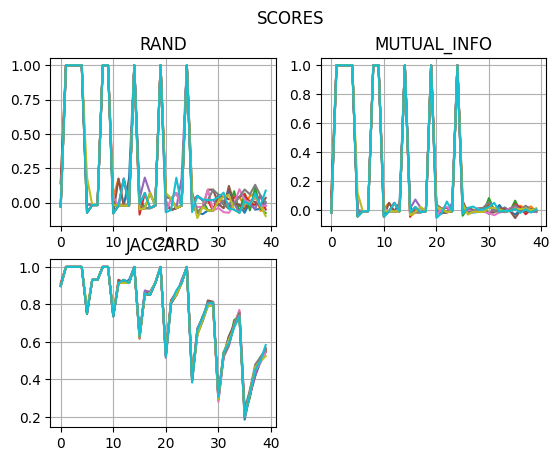

In [28]:
# Display results
print('rand', all_rand)
print('mutual_info', all_mutual)
print('jaccard', all_jaccard)

plt.subplot(2, 2, 1)
plt.plot(all_rand)
plt.xlabel()
plt.ylabel('score')
plt.title('RAND')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(all_mutual)
plt.xlabel()
plt.ylabel('score')
plt.title('MUTUAL_INFO')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(all_jaccard)
plt.xlabel()
plt.ylabel('score')
plt.title('JACCARD')
plt.grid()


plt.suptitle('SCORES')
plt.show()


In [7]:
def get_distance_matrix_one_feast(feast_id, compare_func, sources):
    source_chants_dict = {}
    filt_feast = data['feast_id'] == feast_id
    chants_of_feast = data[filt_feast]
    for source_id in sources:
        filt_source = chants_of_feast['source_id'] == source_id
        if (chants_of_feast[filt_source]['cantus_id']).tolist() != []:
            source_chants_dict[source_id] = (chants_of_feast[filt_source]['cantus_id']).tolist()
    
    all_pairs = [(a, b) for idx, a in enumerate(source_chants_dict.keys()) for b in list(source_chants_dict.keys())[idx + 1:]]
    distance_matrix = np.zeros([len(sources), len(sources)])
    for s_i, s_j in all_pairs:
        distance_matrix[translate_source(s_i), translate_source(s_j)] = 1 - compare_func(source_chants_dict[s_i], source_chants_dict[s_j])
    
    return distance_matrix

In [8]:
def run_feast_chants(n, eps, min_samples, feast_id):
    community_variants = []
    num_of_clusters = []
    drupals = sources['drupal_path'].tolist()
    for _ in range(n):
            perm = list(range(len(drupals)))
            random.shuffle(perm)
            shuff_sources = shuffle(perm, drupals)
            distance_matrix = get_distance_matrix_one_feast(feast_id, Jaccard_metrics, shuff_sources)
            clustering = DBSCAN(eps=eps, min_samples=min_samples)
            clustering.fit(distance_matrix)
            num_of_clusters.append(len(set(clustering.labels_)))
            labels = unshuffle(perm, clustering.labels_)
            community_variants.append(labels)
    print(eps, min_samples)
    print(num_of_clusters)
    return community_variants, num_of_clusters


In [13]:
# Run clustering by feasts
best_feasts_params = {}
for  feast_id in feasts['id'].tolist():
    best_feasts_params[feast_id] = {'jaccard' : {'value' : 0, 'params' : (0, 0), 'avg_clus' : 0}, 
                                    'mutual' : {'value' : 0, 'params' : (0, 0), 'avg_clus' : 0}}


num_of_clusters_by_f = {}
more_groups = []

jaccard_all_scores = {}

for feast_id in feasts_without_little['id'].tolist():
    num_of_clusters_by_f[feast_id] = []
    jaccard_all_scores[feast_id] = []
    for i in range(len(EPS_OPTIONS)):
        for j in range(len(MIN_SAMPLES_OPTIONS)):
            community_variants, num_of_labels = run_feast_chants(n=10, eps=EPS_OPTIONS[i], min_samples=MIN_SAMPLES_OPTIONS[j], feast_id=feast_id)
            
            num_of_clusters_by_f[feast_id].append(num_of_labels)

            jaccard_by_f = []
            mutual_info_by_f = []
            all_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
            for pair in all_pairs:
                mutual_info_by_f.append(adjusted_mutual_info_score(pair[0], pair[1]))
                jaccard_by_f.append(jaccard_score(pair[0], pair[1], average='micro'))
            
            if best_feasts_params[feast_id]['jaccard']['value'] < np.mean(jaccard_by_f) and np.mean(num_of_labels) > 1:
                best_feasts_params[feast_id]['jaccard']['value'] = np.mean(jaccard_by_f)
                best_feasts_params[feast_id]['jaccard']['params'] = (EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])
                best_feasts_params[feast_id]['jaccard']['avg_clus'] = np.mean(num_of_labels)
            if best_feasts_params[feast_id]['mutual']['value'] < np.mean(mutual_info_by_f) and np.mean(num_of_labels) > 1:
                best_feasts_params[feast_id]['mutual']['value'] = np.mean(mutual_info_by_f)
                best_feasts_params[feast_id]['mutual']['params'] = (EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])
                best_feasts_params[feast_id]['mutual']['avg_clus'] = np.mean(num_of_labels)

            jaccard_all_scores[feast_id].append(jaccard_by_f)

            if np.mean(num_of_labels) > 1:
                more_groups.append([feast_id, (np.mean(num_of_labels), EPS_OPTIONS[i], MIN_SAMPLES_OPTIONS[j])])

0.1 2
[3, 2, 2, 2, 2, 2, 2, 3, 2, 2]
0.1 3
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.1 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.1 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.1 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.2 2
[3, 2, 3, 2, 3, 2, 2, 3, 2, 3]
0.2 3
[2, 3, 2, 2, 2, 2, 2, 2, 3, 2]
0.2 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.2 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.2 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.3 2
[2, 3, 2, 2, 3, 2, 3, 3, 3, 2]
0.3 3
[2, 2, 3, 2, 2, 3, 2, 2, 2, 3]
0.3 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.3 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.3 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.4 2
[2, 3, 2, 2, 3, 3, 3, 2, 2, 3]
0.4 3
[2, 2, 2, 2, 3, 3, 2, 3, 2, 2]
0.4 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.4 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.4 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.5 2
[2, 3, 3, 2, 3, 3, 3, 3, 3, 3]
0.5 3
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.5 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.5 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.5 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.6 2
[3, 3, 3, 3, 3, 2, 2, 3, 2, 2]
0.6 3
[2, 2, 3, 2, 3, 3, 2, 2, 2, 2]
0

In [15]:
print('Mean of means of num of clusters on feasts:', np.mean([np.mean(x) for x in num_of_clusters_by_f.values()]))

Mean of means of num of clusters on feasts: 3.3533785529715754


In [16]:
print('max jaccard', max(jaccard_by_f))
print('min_jaccard', min(jaccard_by_f))
print('mean_jaccard', np.mean(jaccard_by_f))

max jaccard 0.5342465753424658
min_jaccard 0.46405228758169936
mean_jaccard 0.5048918304736869


In [21]:
print(best_feasts_params)
print(len(best_feasts_params))

{'feast_0001': {'jaccard': {'value': 0, 'params': (0, 0), 'avg_clus': 0}, 'mutual': {'value': 0, 'params': (0, 0), 'avg_clus': 0}}, 'feast_0002': {'jaccard': {'value': 0.9448573418914931, 'params': (0.4, 4), 'avg_clus': 2.0}, 'mutual': {'value': 0.013550064476022465, 'params': (0.8, 2), 'avg_clus': 2.7}}, 'feast_0003': {'jaccard': {'value': 0.6751447547318588, 'params': (0.8, 3), 'avg_clus': 3.9}, 'mutual': {'value': 0.009982194551343823, 'params': (0.7, 2), 'avg_clus': 6.1}}, 'feast_0004': {'jaccard': {'value': 0.9859092543640563, 'params': (0.8, 3), 'avg_clus': 1.5}, 'mutual': {'value': 0.22112416959955605, 'params': (0.8, 3), 'avg_clus': 1.5}}, 'feast_0005': {'jaccard': {'value': 0, 'params': (0, 0), 'avg_clus': 0}, 'mutual': {'value': 0, 'params': (0, 0), 'avg_clus': 0}}, 'feast_0006': {'jaccard': {'value': 0.854442589534413, 'params': (0.8, 3), 'avg_clus': 2.2}, 'mutual': {'value': 0.004421470938032475, 'params': (0.6, 6), 'avg_clus': 2.0}}, 'feast_0007': {'jaccard': {'value': 0.7